# CNN + GlobalAvgPool
Measure AUPRC

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-24 17:49:26.137959
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=4000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE =   'CNRCI_coding_train_counts.K4.gc42.csv'
PICKLE_FILE =   'CNRCI_coding_combined_K4.pkl'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_max = None
                    rci_count = 0
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            if rci_max is None or rci_val > rci_max:
                                rci_max = rci_val
                            rci_count += 1
                        cell_line += 1   
                    if rci_count > 0:
                        gene_to_rci[gene_id] = rci_max
                        overall_sum += rci_max
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        cache = DATA_DIR+PICKLE_FILE # TO DO: parameterize
        if isfile(cache):
            with open(cache,'rb') as fin:
                alldata = pickle.load(fin)
                labels=alldata[0]
                allids=alldata[1]
                allseq=alldata[2]
                return labels,allids,allseq

        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        with open(cache,'wb') as fout:
            alldata = [labels,allids,allseq]
            pickle.dump(alldata,fout)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-24 17:49:35.373559
Load RCI values...
Number of RCI values 13512
Mean RCI value 0.742330935725574
Num RCI: 13512
Example RCI: [('ENSG00000000003', 2.29436), ('ENSG00000000419', 2.1946), ('ENSG00000000457', 0.434284)]
Load genes...
2023-01-24 17:49:35.464747
Load sequence...
2023-01-24 17:49:41.769101
Num IDs: 54410
Example IDs: [('ENSG00000187634', 'ENST00000455979.1'), ('ENSG00000187608', 'ENST00000624652.1'), ('ENSG00000131591', 'ENST00000427787.5'), ('ENSG00000186827', 'ENST00000699969.1')]
Count 40851 ones out of 54410 labels.
Num labels: 54410
Example labels: [0, 1, 0, 0]
Num sequences: 54410
Example sequence: [147, 73, 35, 138, 38, 150, 85, 83, 74, 37, 147, 73, 36, 142, 54, 214, 88, 95, 122, 231, 155, 106, 167, 156, 112, 190, 247, 218, 103, 153, 99, 139, 43, 172, 175, 187, 235, 169, 162, 135, 27, 107, 169, 161, 131, 10, 39, 155, 107, 170, 168, 159, 123, 235, 169, 161, 131, 12, 46, 183, 219, 107, 170, 166, 151, 89, 99, 139, 43, 169, 161, 129, 1, 3, 12, 46, 184, 223, 121, 2

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-01-24 17:49:41.805265
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 3982, 64)          4160      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,253
Trainable params: 5,253
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [10]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )

            print(datetime.now())

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print('Train sizes',X_train.shape,y_train.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))

            print("Compute valiation accuracy")
            print(datetime.now())
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Score threshold',self.threshold)
            print('Prediction set ones/size',
                  np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            
            plt.plot(prc_X, prc_Y, marker='.')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%%' % (f1,auprc)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auc.append(auprc)
            
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            train_genes = None
            X_valid = None
            y_valid = None
            valid_genes = None
            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auc

2023-01-24 17:49:45.185331
2023-01-24 17:49:45.185470
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-24 17:49:55.845887
Epoch 1/3
1356/1356 [==============================] - 20s 8ms/step - loss: 0.5473 - accuracy: 0.7493 - val_loss: 0.5208 - val_accuracy: 0.7674
Epoch 2/3
1356/1356 [==============================] - 11s 8ms/step - loss: 0.5404 - accuracy: 0.7524 - val_loss: 0.5264 - val_accuracy: 0.7651
Epoch 3/3
1356/1356 [==============================] - 11s 8ms/step - loss: 0.5378 - accuracy: 0.7541 - val_loss: 0.5206 - val_accuracy: 0.7669
2023-01-24 17:50:38.746349


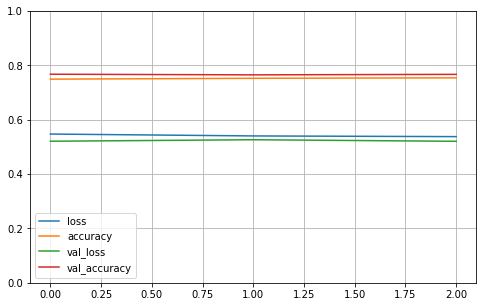

Train sizes (43381, 3997) (43381, 1)
Train set ones/size 32398 / 43381
Compute valiation accuracy
2023-01-24 17:50:38.932475
Valid sizes (11029, 3997) (11029, 1)
Valid set ones/size 8453 / 11029
Range of scores: 0.1160465 to 0.95846397
Score threshold 0.5
Prediction set ones/size 10722 / 11029


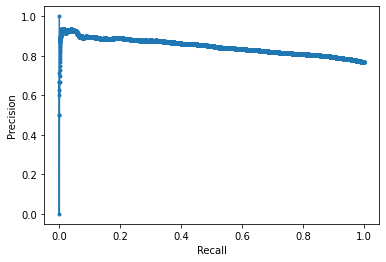

Accuracy: 76.69% Precision: 77.43% Recall: 98.21%
F1: 86.59% AUPRC: 84.70%
2023-01-24 17:50:40.376142
Fold 2
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-24 17:50:53.000754
Epoch 1/3
1358/1358 [==============================] - 11s 8ms/step - loss: 0.5464 - accuracy: 0.7518 - val_loss: 0.5307 - val_accuracy: 0.7525
Epoch 2/3
1358/1358 [==============================] - 11s 8ms/step - loss: 0.5385 - accuracy: 0.7548 - val_loss: 0.5293 - val_accuracy: 0.7543
Epoch 3/3
1358/1358 [==============================] - 11s 8ms/step - loss: 0.5361 - accuracy: 0.7560 - val_loss: 0.5283 - val_accuracy: 0.7563
2023-01-24 17:51:27.138125


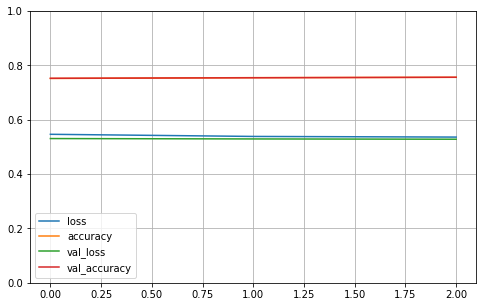

Train sizes (43433, 3997) (43433, 1)
Train set ones/size 32532 / 43433
Compute valiation accuracy
2023-01-24 17:51:27.301124
Valid sizes (10977, 3997) (10977, 1)
Valid set ones/size 8319 / 10977
Range of scores: 0.2109116 to 0.9814207
Score threshold 0.5
Prediction set ones/size 10578 / 10977


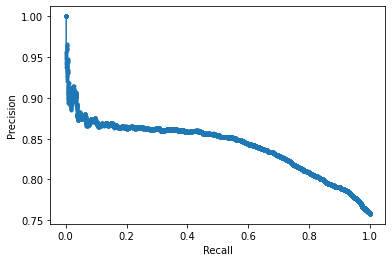

Accuracy: 75.63% Precision: 76.68% Recall: 97.50%
F1: 85.84% AUPRC: 84.15%
2023-01-24 17:51:28.484664
Fold 3
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-24 17:51:41.590976
Epoch 1/3
1354/1354 [==============================] - 11s 8ms/step - loss: 0.5443 - accuracy: 0.7517 - val_loss: 0.5360 - val_accuracy: 0.7583
Epoch 2/3
1354/1354 [==============================] - 11s 8ms/step - loss: 0.5375 - accuracy: 0.7544 - val_loss: 0.5339 - val_accuracy: 0.7587
Epoch 3/3
1354/1354 [==============================] - 11s 8ms/step - loss: 0.5350 - accuracy: 0.7548 - val_loss: 0.5374 - val_accuracy: 0.7550
2023-01-24 17:52:14.802562


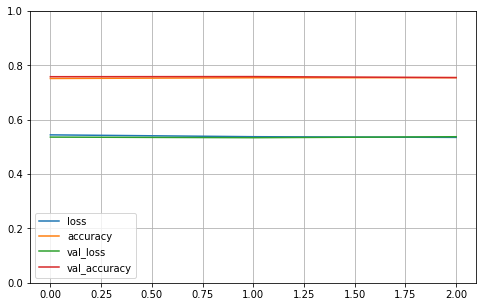

Train sizes (43311, 3997) (43311, 1)
Train set ones/size 32481 / 43311
Compute valiation accuracy
2023-01-24 17:52:14.954670
Valid sizes (11099, 3997) (11099, 1)
Valid set ones/size 8370 / 11099
Range of scores: 0.19287363 to 0.96577346
Score threshold 0.5
Prediction set ones/size 10551 / 11099


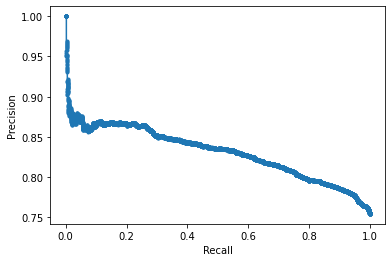

Accuracy: 75.50% Precision: 76.78% Recall: 96.79%
F1: 85.63% AUPRC: 83.13%
2023-01-24 17:52:16.161221
Fold 4
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-24 17:52:28.910940
Epoch 1/3
1366/1366 [==============================] - 11s 8ms/step - loss: 0.5400 - accuracy: 0.7558 - val_loss: 0.5564 - val_accuracy: 0.7404
Epoch 2/3
1366/1366 [==============================] - 11s 8ms/step - loss: 0.5327 - accuracy: 0.7571 - val_loss: 0.5655 - val_accuracy: 0.7409
Epoch 3/3
1366/1366 [==============================] - 11s 8ms/step - loss: 0.5300 - accuracy: 0.7581 - val_loss: 0.5549 - val_accuracy: 0.7416
2023-01-24 17:53:02.891343


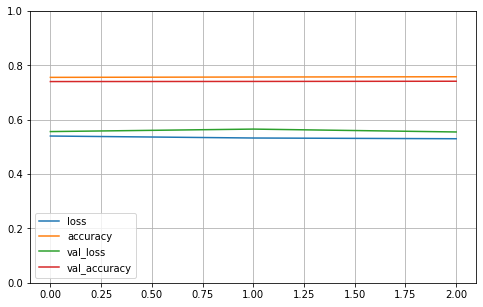

Train sizes (43698, 3997) (43698, 1)
Train set ones/size 32959 / 43698
Compute valiation accuracy
2023-01-24 17:53:03.050300
Valid sizes (10712, 3997) (10712, 1)
Valid set ones/size 7892 / 10712
Range of scores: 0.16366057 to 0.98095864
Score threshold 0.5
Prediction set ones/size 10098 / 10712


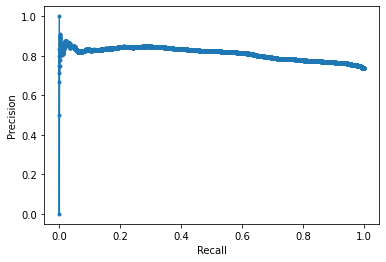

Accuracy: 74.16% Precision: 75.37% Recall: 96.44%
F1: 84.61% AUPRC: 81.20%
2023-01-24 17:53:04.686269
Fold 5
Training example
[169 163 140 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-24 17:53:17.915785
Epoch 1/3
1370/1370 [==============================] - 12s 8ms/step - loss: 0.5419 - accuracy: 0.7544 - val_loss: 0.5480 - val_accuracy: 0.7496
Epoch 2/3
1370/1370 [==============================] - 11s 8ms/step - loss: 0.5347 - accuracy: 0.7559 - val_loss: 0.5476 - val_accuracy: 0.7495
Epoch 3/3
1370/1370 [==============================] - 11s 8ms/step - loss: 0.5324 - accuracy: 0.7575 - val_loss: 0.5443 - val_accuracy: 0.7486
2023-01-24 17:54:00.653793


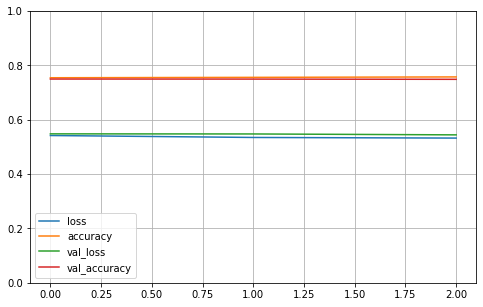

Train sizes (43817, 3997) (43817, 1)
Train set ones/size 33034 / 43817
Compute valiation accuracy
2023-01-24 17:54:00.824735
Valid sizes (10593, 3997) (10593, 1)
Valid set ones/size 7817 / 10593
Range of scores: 0.19603963 to 0.9748302
Score threshold 0.5
Prediction set ones/size 10160 / 10593


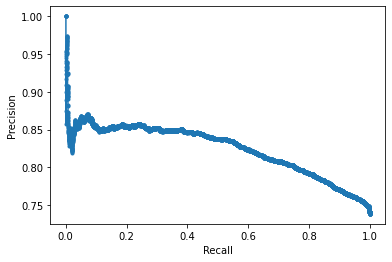

Accuracy: 74.86% Precision: 75.36% Recall: 97.95%
F1: 85.19% AUPRC: 82.48%
2023-01-24 17:54:02.021771

Cross validation 5 folds 3 epochs
 accuracy mean 75.37% +/- 0.84
 precision mean 76.32% +/- 0.82
 recall mean 97.38% +/- 0.67
 F1 mean 85.57% +/- 0.66
 AUC mean 83.13% +/- 1.24
2023-01-24 17:54:04.156470


In [11]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auc = cvdo.do_cross_validation()   
cvdo = None
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(" AUC mean %.2f%% +/- %.2f" % (np.mean(cv_auc), np.std(cv_auc)))
print(datetime.now())